## Using different models according to paper

# Import stock data


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [34]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='MAINUT5068DCQGJ9',output_format='pandas')
# Get json object with the intraday data and another with  the call's metadata



# get all available daily data (Netflix)
mydata, meta_data = ts.get_daily('NFLX',outputsize='full')

Text(0.5,0,'Date')

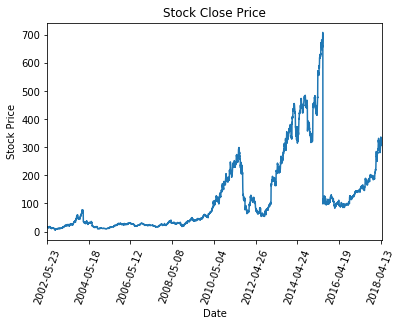

In [35]:
#data.head()
mydata['4. close'].plot()
plt.xticks(rotation=70)
plt.title('Stock Close Price')
plt.ylabel('Stock Price')
plt.xlabel('Date')

## Pre-processing
Choice of no preprocessing, differencing or Moving Average with N=5

In [36]:
dataset = mydata['4. close'].loc['2017-04-26':'2018-04-26'].values
dataset = dataset.astype('float32')

In [37]:
preproc = input("What Preprocessing do you like? None (N), Differencing (D) or Moving Average (M): ")
print("You chose: ", preproc)
#type(preproc)


What Preprocessing do you like? None (N), Differencing (D) or Moving Average (M): N
You chose:  N


In [38]:
if preproc == 'D':
    dataset = np.diff(dataset)
    print('Differencing applied')
elif preproc == 'M':
    cumsum = np.cumsum(np.insert(dataset, 0, 0)) 
    dataset = (cumsum[5:] - cumsum[:-5]) / float(5)
    print('Moving Average applied')
else:
    dataset = dataset
    print('no preprocessing applied')

no preprocessing applied


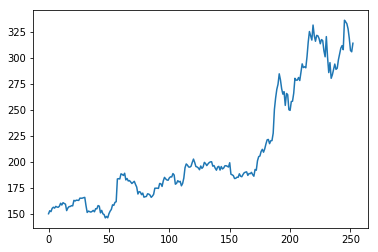

In [39]:
plt.plot(dataset)

In [40]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

169 84


# Neural Network


In [41]:
from keras.models import Sequential
from keras.layers import Dense

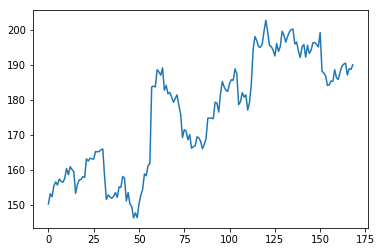

In [42]:
plt.plot(train)

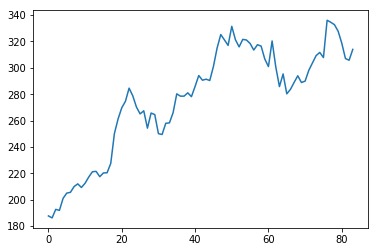

In [43]:
plt.plot(test)

In [44]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [49]:
look_back = input("How many days in the past do you want to use as feature vector? ")
print("You chose: ", look_back)

How many days in the past do you want to use as feature vector?1
You chose:  1


In [45]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [46]:
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
 - 0s - loss: 24617.1198
Epoch 2/200
 - 0s - loss: 10582.3950
Epoch 3/200
 - 0s - loss: 1913.0322
Epoch 4/200
 - 0s - loss: 82.7304
Epoch 5/200
 - 0s - loss: 10.8600
Epoch 6/200
 - 0s - loss: 10.7329
Epoch 7/200
 - 0s - loss: 10.7712
Epoch 8/200
 - 0s - loss: 10.7532
Epoch 9/200
 - 0s - loss: 10.8108
Epoch 10/200
 - 0s - loss: 11.0011
Epoch 11/200
 - 0s - loss: 10.8321
Epoch 12/200
 - 0s - loss: 10.8128
Epoch 13/200
 - 0s - loss: 10.9328
Epoch 14/200
 - 0s - loss: 11.0456
Epoch 15/200
 - 0s - loss: 10.9116
Epoch 16/200
 - 0s - loss: 10.9263
Epoch 17/200
 - 0s - loss: 10.8049
Epoch 18/200
 - 0s - loss: 11.1654
Epoch 19/200
 - 0s - loss: 11.1357
Epoch 20/200
 - 0s - loss: 10.7495
Epoch 21/200
 - 0s - loss: 10.8753
Epoch 22/200
 - 0s - loss: 10.8382
Epoch 23/200
 - 0s - loss: 10.8086
Epoch 24/200
 - 0s - loss: 11.0200
Epoch 25/200
 - 0s - loss: 10.9811
Epoch 26/200
 - 0s - loss: 11.4578
Epoch 27/200
 - 0s - loss: 11.2299
Epoch 28/200
 - 0s - loss: 11.2771
Epoch 29/200
 - 0s - 

In [47]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 11.65 MSE (3.41 RMSE)
Test Score: 79.47 MSE (8.91 RMSE)


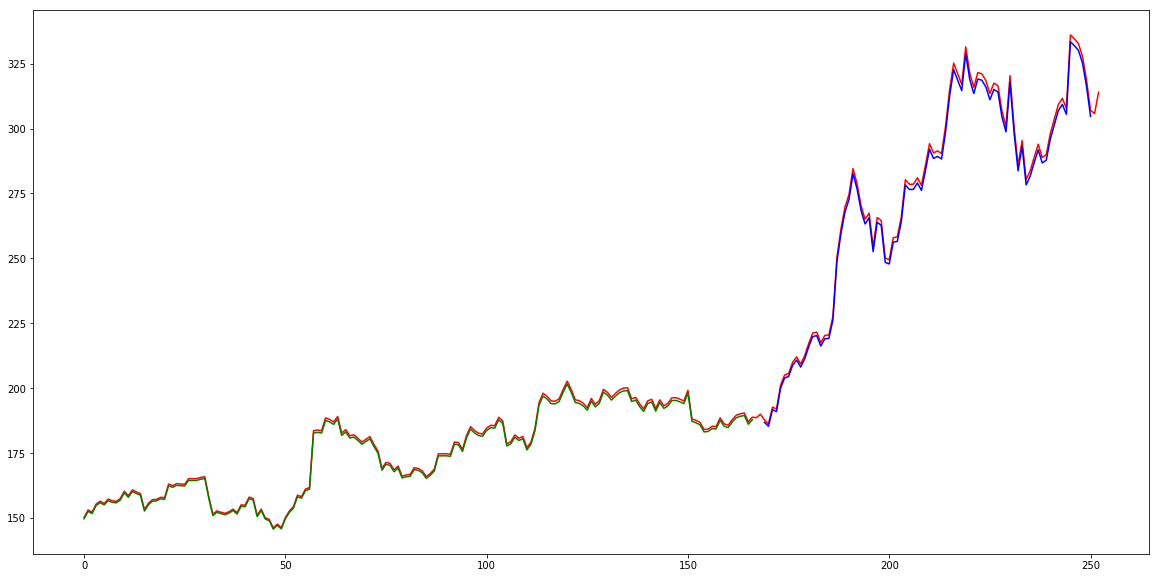

In [48]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1] = trainPredict[:,0]

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset)-2] = testPredict[:,0]

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(dataset,'r')
plt.plot(trainPredictPlot,'g')
plt.plot(testPredictPlot,'b')
plt.show()